# Clean train Data

In [2]:
# Manage imports
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt

In [155]:
%run functions.py

In [3]:
# read data in memory
#data = pd.read_csv("C:\\Users\\Leo\\TaxiData\\train.csv",index_col=0)
data = pd.read_csv("train.csv")

In [9]:
sns.set(font_scale=2) 
sns.set_style("whitegrid")

## Look into raw dataset

In [4]:
data.RatecodeID.value_counts()

1     10815797
2       255270
5        36270
3        22195
4         5549
99         272
6          117
Name: RatecodeID, dtype: int64

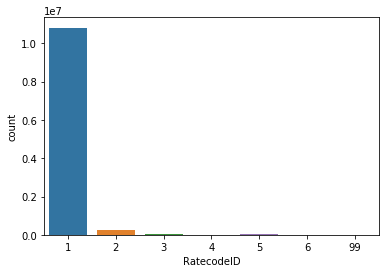

In [5]:
plt.figure()
sns.countplot(data.RatecodeID)
plt.savefig('RatecodeDist.pdf')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11135470 entries, 0 to 11135469
Data columns (total 19 columns):
VendorID                 int64
tpep_pickup_datetime     object
tpep_dropoff_datetime    object
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int64
store_and_fwd_flag       object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtypes: float64(12), int64(4), object(3)
memory usage: 1.6+ GB


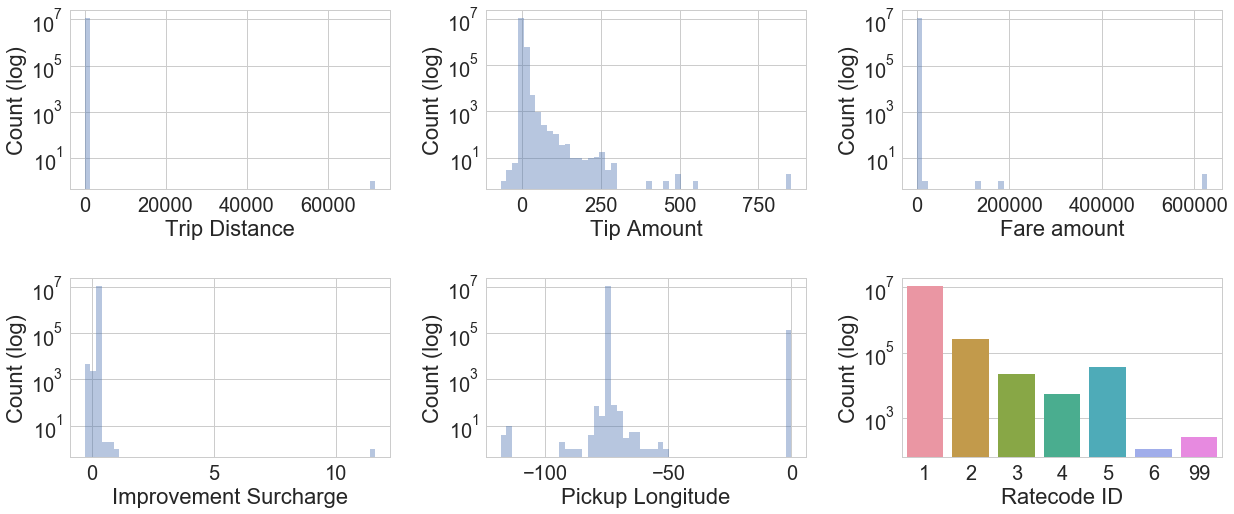

In [8]:
plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
ax = sns.distplot(data.trip_distance, hist_kws={'log':True},kde=False)
ax.set(xlabel='Trip Distance', ylabel='Count (log)')

plt.subplot(2,3,2)
ax = sns.distplot(data.tip_amount, hist_kws={'log':True},kde=False)
ax.set(xlabel='Tip Amount', ylabel='Count (log)')

plt.subplot(2,3,3)
ax = sns.distplot(data.fare_amount, hist_kws={'log':True},kde=False)
ax.set(xlabel='Fare amount', ylabel='Count (log)')

plt.subplot(2,3,4)
ax = sns.distplot(data.improvement_surcharge, hist_kws={'log':True},kde=False)
ax.set(xlabel='Improvement Surcharge', ylabel='Count (log)')

plt.subplot(2,3,5)
ax = sns.distplot(data.pickup_longitude,hist_kws={'log':True},kde=False)
ax.set(xlabel='Pickup Longitude', ylabel='Count (log)')

plt.subplot(2,3,6)
ax = sns.countplot(data.RatecodeID)
ax.set_yscale('log')
ax.set(xlabel='Ratecode ID', ylabel='Count (log)')

plt.subplots_adjust(left=0.1, wspace=0.3, hspace=0.5, top=.9)


plt.savefig('plots/Outliers.pdf')
plt.savefig('plots/Outliers.png')

## Clean obvious wrong data

Clean the data.
Remove all obvious outliers:
* Invalid Ratecoded (must be in range 1,2,3,4,5,6)
* Invalid improvement_surcharge (only .3 is valid!)
* Invalid mta_tax (either 0 or .5)
* Invalid extra (0,0.5,1,1.5,4.5)
* All negative values (costs can't be negative!)
* Drop useless information
    * store_and_fwd_flag (Useless)
    * Vendor ID (Useless)
    * Improvement surcharge (Fixed value!)
* Calculate total amount, drop outliers (values which doesnt equal to the total amount must be wrong!)
* Save pickup and dropoff time as datetime object

In [11]:
df = data
print(df.shape)
# Drop all data with invalid extra, improvement_surcharge, RatecodeID, mta_tax -> Invalid!
df = data.drop(data[data.extra.isin([0,0.5,1,1.5,4.5]) == False].index)
print(df.shape)
df = df.drop(df[df.improvement_surcharge!=0.3].index)
print(df.shape)
# Also drop 6 -> No group rides in test data!
df = df.drop(df[df.RatecodeID.isin([1,2,3,4,5]) == False].index)
print(df.shape)
df = df.drop(df[df.mta_tax.isin([0,0.5]) == False].index)
print(df.shape)

df = df.drop(df[df.tip_amount < 0].index)
df = df.drop(df[df.fare_amount <= 0].index)
df = df.drop(df[df.total_amount <= 0].index)
df = df.drop(df[df.tolls_amount < 0].index)
df = df.drop(df[df.pickup_latitude == 0].index)
df = df.drop(df[df.pickup_longitude == 0].index)
df = df.drop(df[df.dropoff_latitude == 0].index)
df = df.drop(df[df.dropoff_longitude == 0].index)
print(df.shape)

(11135470, 19)
(11133123, 19)
(11128278, 19)
(11128037, 19)
(11128037, 19)
(10973256, 19)


In [12]:
df.RatecodeID.value_counts()

1    10670060
2      249517
5       26576
3       21660
4        5443
Name: RatecodeID, dtype: int64

In [13]:
data.RatecodeID.value_counts()

1     10815797
2       255270
5        36270
3        22195
4         5549
99         272
6          117
Name: RatecodeID, dtype: int64

In [14]:
# Drop useless columns
df = df.drop(['VendorID','store_and_fwd_flag','improvement_surcharge'],axis=1)

In [15]:
df.groupby(['RatecodeID']).mta_tax.value_counts()
#ax = df.groupby(['RatecodeID']).mta_tax.value_counts().plot(kind='bar', figsize=(15, 5))
#ax.set_xlabel('RatecodeID', fontsize=18)
#ax.set_ylabel('Number of trips', fontsize=18)
#ax.tick_params(labelsize=12)

RatecodeID  mta_tax
1           0.5        10668433
            0.0            1627
2           0.5          249400
            0.0             117
3           0.0           21655
            0.5               5
4           0.5            5443
5           0.0           19588
            0.5            6988
Name: mta_tax, dtype: int64

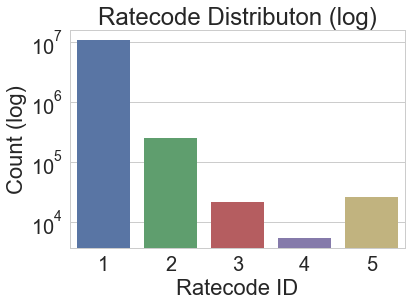

In [19]:
ax = sns.countplot(df.RatecodeID)
plt.title('Ratecode Distributon (log)')
ax.set_yscale('log')
ax.set(xlabel='Ratecode ID', ylabel='Count (log)')


plt.savefig('plots/RatecodeDist.pdf')
plt.savefig('plots/RatecodeDist.png')

In [25]:
df['tpep_pickup_datetime'] = pd.to_datetime(df.tpep_pickup_datetime)
df['tpep_dropoff_datetime'] = pd.to_datetime(df.tpep_dropoff_datetime)

df['pickup_time'] = df.tpep_pickup_datetime - pd.to_datetime(df.tpep_pickup_datetime.dt.date)
df['dropoff_time'] = df.tpep_dropoff_datetime - pd.to_datetime(df.tpep_dropoff_datetime.dt.date)

In [72]:
data['tpep_pickup_datetime'] = pd.to_datetime(data.tpep_pickup_datetime)
data['tpep_dropoff_datetime'] = pd.to_datetime(data.tpep_dropoff_datetime)

data['pickup_time'] = data.tpep_pickup_datetime - pd.to_datetime(data.tpep_pickup_datetime.dt.date)
data['dropoff_time'] = data.tpep_dropoff_datetime - pd.to_datetime(data.tpep_dropoff_datetime.dt.date)

In [80]:
data = data.drop(data[data.extra.isin([0,0.5,1,1.5,4.5]) == False].index)


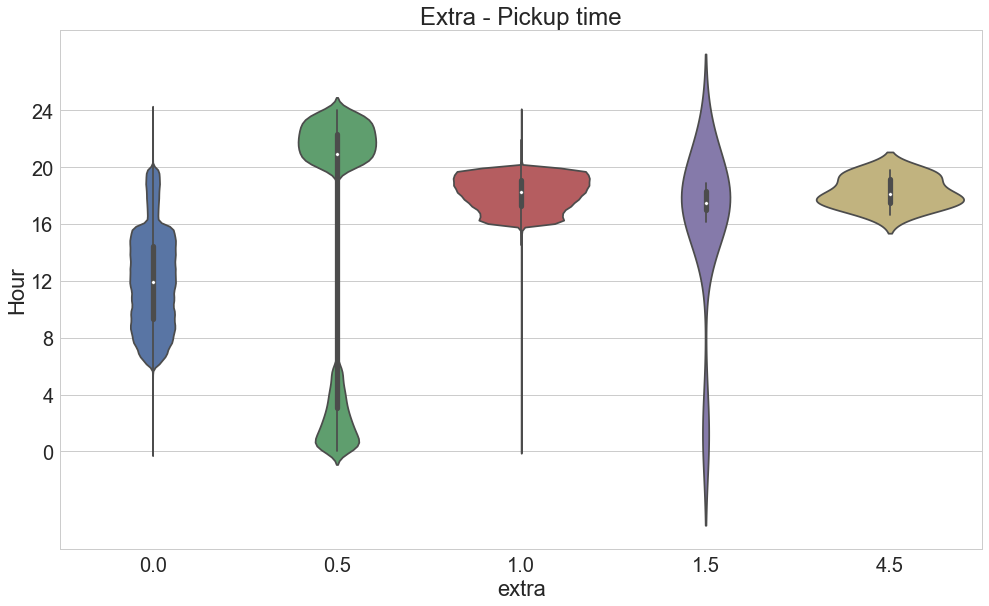

In [126]:
sample = data[(data.RatecodeID == 1)]
plt.figure(figsize=(16,9))


sns.violinplot(x=sample.extra,y=sample.pickup_time.astype('timedelta64[s]'))
plt.title('Extra - Pickup time')

plt.yticks(np.arange((1440*60)+1,step=(240)*60),np.arange(25,step=4))
plt.ylabel('Hour')

plt.subplots_adjust(left=0.1, top=.9, bottom=0.10)

plt.savefig('plots/ExtraPickup.pdf')
plt.savefig('plots/ExtraPickup.png')

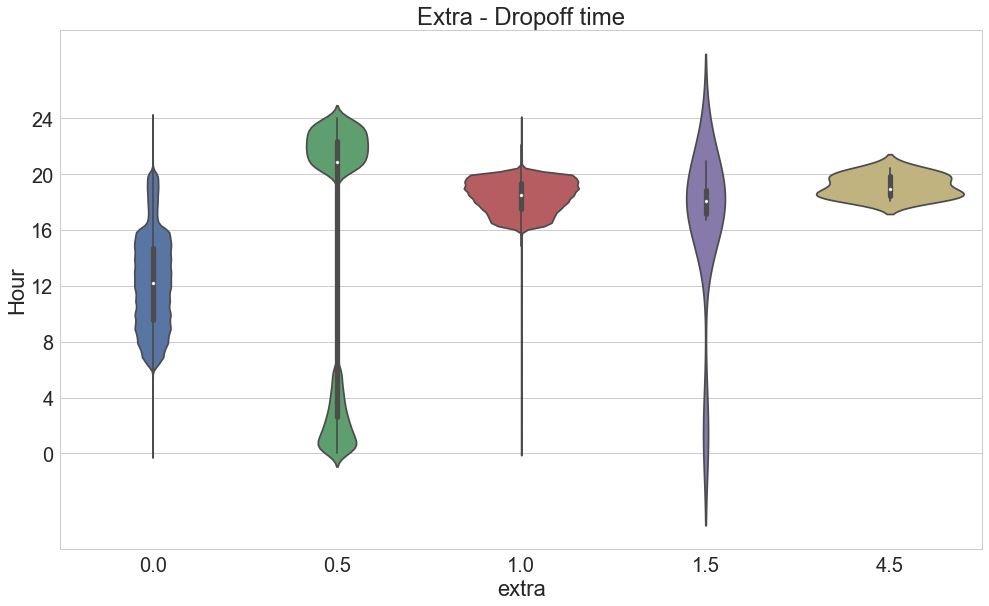

In [127]:
sample = data[(data.RatecodeID == 1)]
plt.figure(figsize=(16,9))


sns.violinplot(x=sample.extra,y=sample.dropoff_time.astype('timedelta64[s]'))
plt.title('Extra - Dropoff time')

plt.yticks(np.arange((1440*60)+1,step=(240)*60),np.arange(25,step=4))
plt.ylabel('Hour')


plt.subplots_adjust(left=0.1, top=.9, bottom=0.10)

plt.savefig('plots/ExtraDropoff.pdf')
plt.savefig('plots/ExtraDropoff.png')

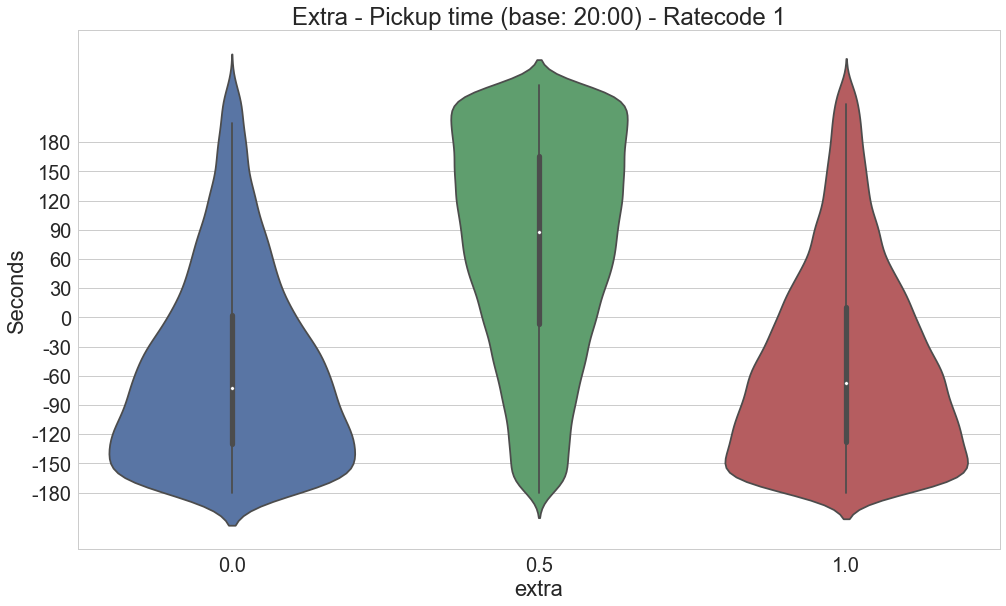

In [128]:
sample = data[(data.pickup_time.astype('timedelta64[m]') >= 1197) & (data.pickup_time.astype('timedelta64[m]') <= 1203)\
           & (data.RatecodeID == 1)]
plt.figure(figsize=(16,9))


plt.title('Extra - Pickup time (base: 20:00) - Ratecode 1')
sns.violinplot(x=sample.extra,y=sample.pickup_time.astype('timedelta64[s]'))
plt.yticks(np.arange((1197*60),(1203*60)+1,step=30),np.arange(-180,181,step=30))
plt.ylabel('Seconds')
plt.subplots_adjust(left=0.1, top=.9, bottom=0.10)

plt.savefig('plots/ExtraPickup20.pdf')
plt.savefig('plots/ExtraPickup20.png')

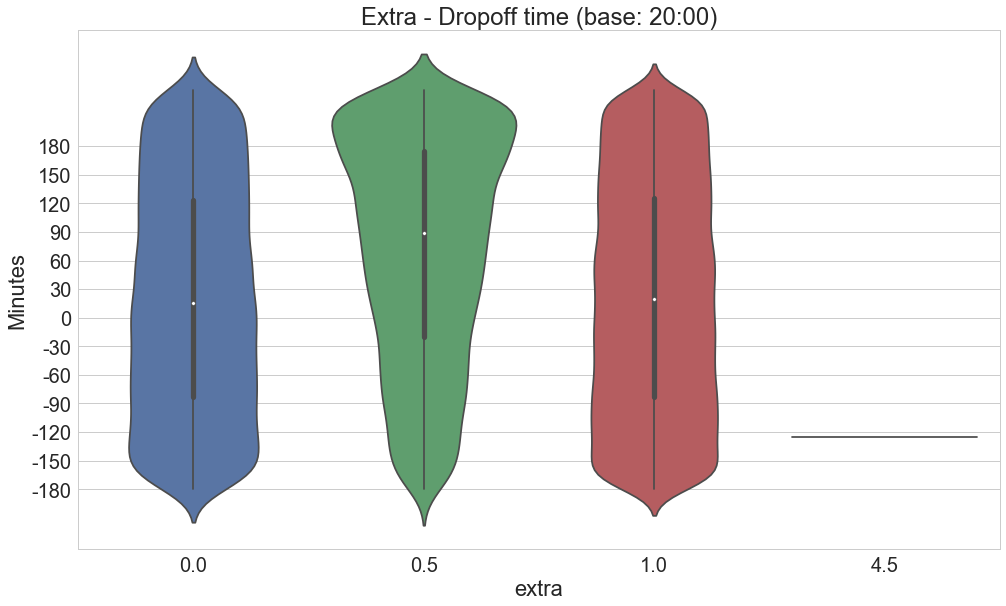

In [130]:
sample = data[(data.dropoff_time.astype('timedelta64[m]') >= 1197) & (data.dropoff_time.astype('timedelta64[m]') <= 1203)\
           & (data.RatecodeID == 1)]
plt.figure(figsize=(16,9))

plt.title('Extra - Dropoff time (base: 20:00)')
sns.violinplot(x=sample.extra,y=sample.dropoff_time.astype('timedelta64[s]'))
plt.yticks(np.arange((1197*60),(1203*60)+1,step=30),np.arange(-180,181,step=30))
plt.ylabel('Minutes')

plt.subplots_adjust(left=0.1, top=.9, bottom=0.10)

plt.savefig('plots/ExtraDropoff20.pdf')
plt.savefig('plots/ExtraDropoff20.png')

In [66]:
df = df.drop(df[(df.RatecodeID !=2) & ((df.extra.isin([0,0.5,1,1.5]))==False)].index)
df = df.drop(df[(df.RatecodeID ==2) & ((df.extra.isin([0,4.5]))==False)].index)
df = df.drop(df[(df.RatecodeID ==3) & (df.mta_tax == .5)].index)
df = df.drop(df[(df.RatecodeID.isin([1,2,4])) & (df.mta_tax == 0)].index)

# Rush Hour on Weekends
df = df.drop(df[(df.extra.isin([1,4.5])) & (pd.to_datetime(df.tpep_pickup_datetime).dt.weekday>=5)].index)
# Rush Hour picked up after 20
df = df.drop(df[(df.extra.isin([1,4.5])) & (pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 20)].index)
# Rush Hour dropped before 16
df = df.drop(df[(df.extra.isin([1,4.5])) & (pd.to_datetime(df.tpep_dropoff_datetime).dt.hour < 16)].index)
# Overnight picked up after 6 and dropped before 20
df = df.drop(df[(df.extra == 0.5) & \
    ((pd.to_datetime(df.tpep_pickup_datetime).dt.hour >= 6) & \
    (pd.to_datetime(df.tpep_dropoff_datetime).dt.hour < 20))].index)

# Remove Dependant on Ratecode invalid data
# All price steps are in 0.5! (excluding negotiated)
df = df.drop(df[(df.RatecodeID !=5) & ((df.fare_amount%0.5)!=0)].index)
df = df.drop(df[(df.RatecodeID ==2) & ((df.fare_amount!=52))].index)
df = df.drop(df[(df.RatecodeID ==3) & ((df.fare_amount<=20))].index)
df = df.drop(df[(df.RatecodeID.isin([1,4,5])) & ((df.fare_amount<3))].index)

# Remove values where total isnt the sum of all
total = df.extra+df.tip_amount+df.tolls_amount+df.mta_tax+df.fare_amount + 0.3
df = df.drop(df[df.total_amount != total].index)

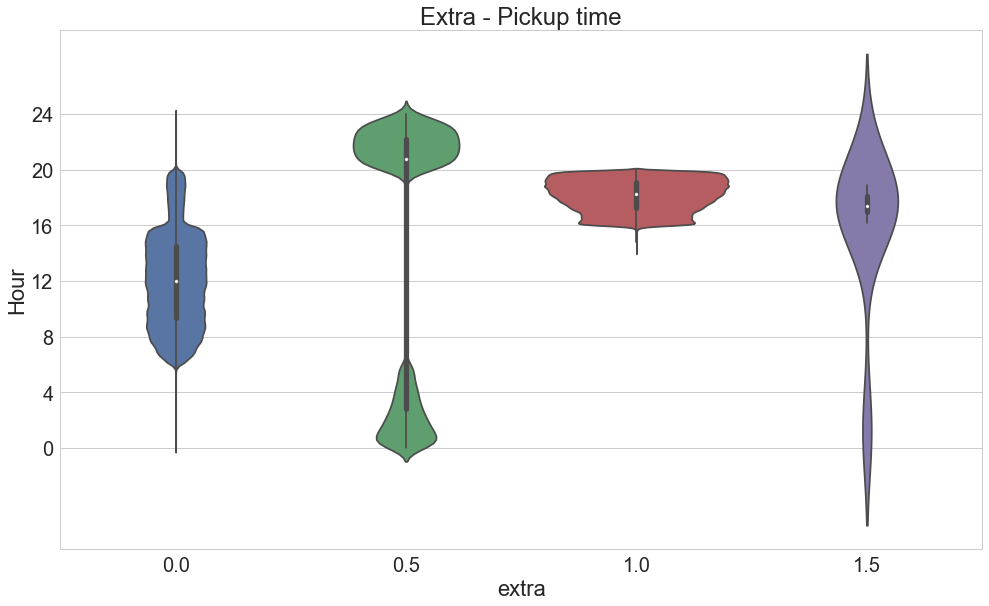

In [125]:
sample = df[(df.RatecodeID == 1)]
plt.figure(figsize=(16,9))

sns.violinplot(x=sample.extra,y=sample.pickup_time.astype('timedelta64[m]'))
plt.title('Extra - Pickup time')

plt.yticks(np.arange(1441,step=240),np.arange(25,step=4))
plt.ylabel('Hour')
plt.subplots_adjust(left=0.1, top=.9, bottom=0.10)

plt.savefig('plots/ExtraPickupClean.pdf')
plt.savefig('plots/ExtraPickupClean.png')

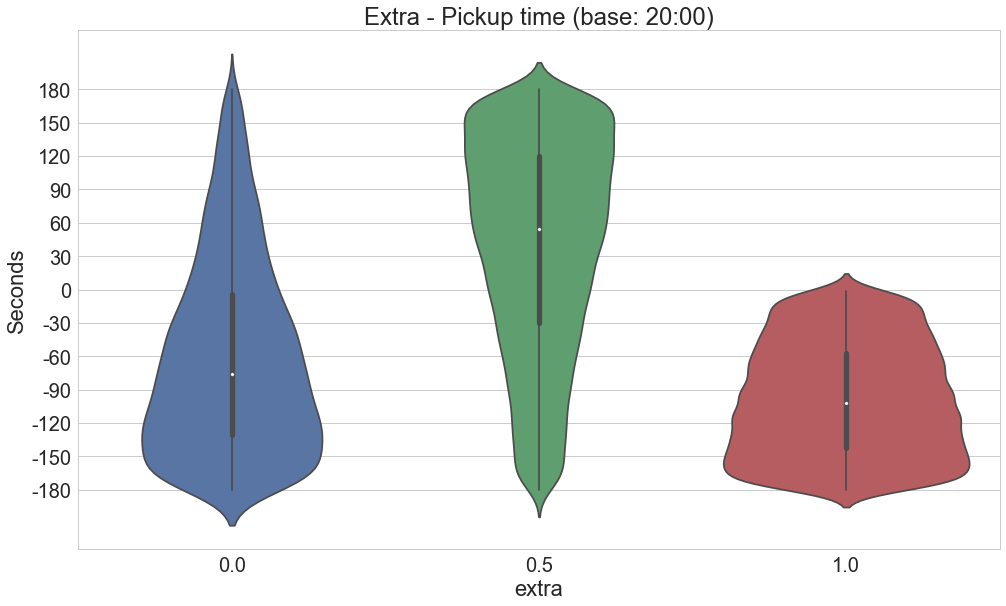

In [122]:
sample = df[(df.pickup_time.astype('timedelta64[s]') >= 1197*60)\
            & (df.pickup_time.astype('timedelta64[s]') <= 1203*60)\
            & (df.RatecodeID == 1)]
plt.figure(figsize=(16,9))

plt.title('Extra - Pickup time (base: 20:00)')
sns.violinplot(x=sample.extra,y=sample.pickup_time.astype('timedelta64[s]'))
plt.yticks(np.arange((1197*60),(1203*60)+1,step=30),np.arange(-180,181,step=30))
plt.ylabel('Seconds')

plt.subplots_adjust(left=0.1, top=.9, bottom=0.10)
plt.savefig('plots/ExtraPickup20Clean.pdf')
plt.savefig('plots/ExtraPickup20Clean.png')


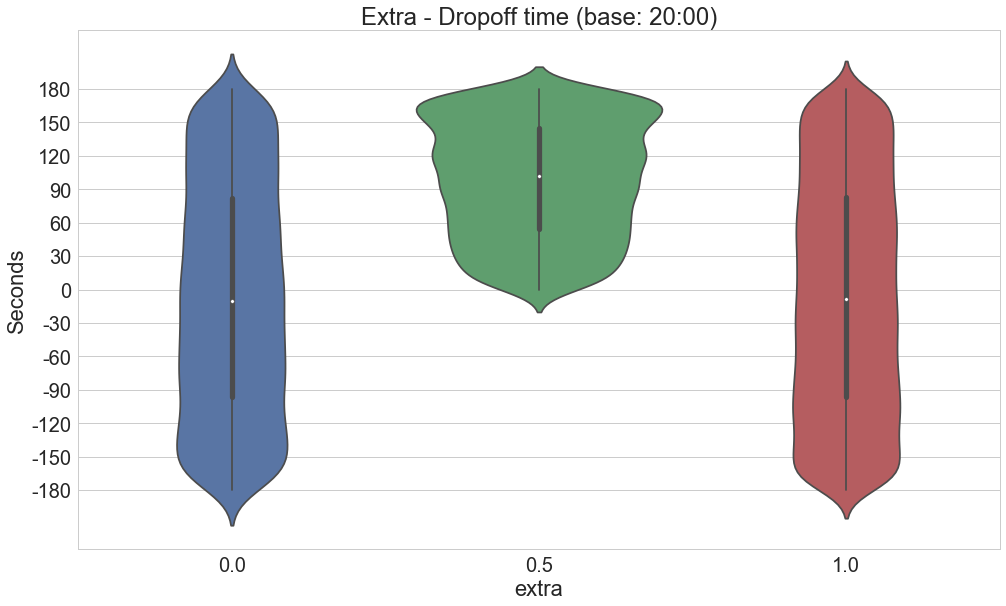

In [123]:
sample = df[(df.dropoff_time.astype('timedelta64[s]') >= 1197*60)\
            & (df.dropoff_time.astype('timedelta64[s]') <= 1203*60)\
            & (df.RatecodeID == 1)]
plt.figure(figsize=(16,9))
plt.title('Extra - Dropoff time (base: 20:00)')
sns.violinplot(x=sample.extra,y=sample.dropoff_time.astype('timedelta64[s]'))
plt.yticks(np.arange((1197*60),(1203*60)+1,step=30),np.arange(-180,181,step=30))
plt.ylabel('Seconds')

plt.subplots_adjust(left=0.1, top=.9, bottom=0.10)
plt.savefig('plots/ExtraDropoff20Clean.pdf')
plt.savefig('plots/ExtraDropoff20Clean.png')



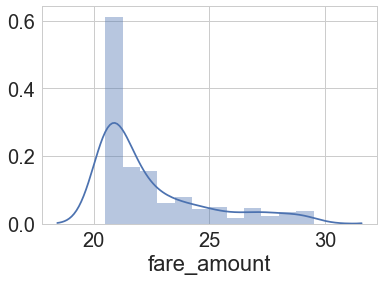

In [124]:
sns.distplot(df[(df.RatecodeID == 3) & (df.fare_amount < 30)].fare_amount)

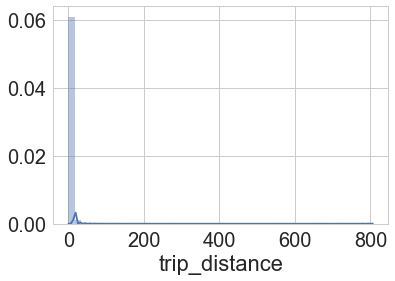

In [131]:
sns.distplot(df.trip_distance)

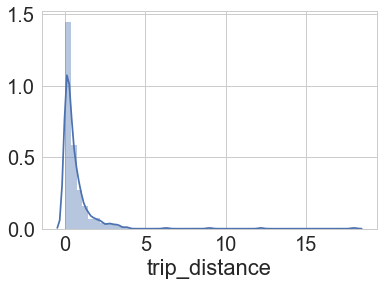

In [132]:
sns.distplot(df[(df.RatecodeID == 3) & (df.fare_amount < 30)].trip_distance)

In [133]:
df[(df.RatecodeID == 3) & (df.fare_amount < 30)].trip_distance.describe()

count    449.000000
mean       0.675479
std        1.304531
min        0.000000
25%        0.100000
50%        0.310000
75%        0.800000
max       18.000000
Name: trip_distance, dtype: float64

In [134]:
df = df.drop(df[df.tolls_amount > 30].index)

df = df.drop(df[df.fare_amount > 400].index)

df = df.drop(df[(df.fare_amount > 80)&(df.RatecodeID==1)].index)
df = df.drop(df[(df.fare_amount > 100)&(df.RatecodeID==2)].index)
df = df.drop(df[(df.fare_amount > 100)&(df.RatecodeID==3)].index)
df = df.drop(df[(df.fare_amount > 100)&(df.RatecodeID==4)].index)
df = df.drop(df[(df.fare_amount > 400)&(df.RatecodeID==5)].index)



df = df.drop(df[(df.passenger_count < 1) | (df.passenger_count > 6)].index)

In [146]:
df = df.drop(df[df.trip_distance > 100].index)
df = df.drop(df[df.tip_amount > 200].index)

In [135]:
#removing outliers (far away from manhattan)
manLat = 40.756716
manLong = -73.985368
margin = 1

print("With outliers:",np.shape(df))
df = df.loc[(abs(df["dropoff_latitude"]-manLat)<margin) 
                   &(abs(df["pickup_latitude"]-manLat)<margin) 
                   &(abs(df["dropoff_longitude"]-manLong)<margin) 
                   &(abs(df["pickup_longitude"]-manLong)<margin)]
print("Without outliers:",np.shape(df))

With outliers: (9111143, 18)
Without outliers: (9110879, 18)


Transform datetime in datetime objects

In [136]:
df["tpep_pickup_datetime"] = pd.to_datetime(df.tpep_pickup_datetime)
df['tpep_dropoff_datetime'] = pd.to_datetime(df.tpep_dropoff_datetime)

In [137]:
# Get duration
df['duration'] = (pd.to_datetime(df["tpep_dropoff_datetime"])-pd.to_datetime(df["tpep_pickup_datetime"]))\
    .astype('timedelta64[s]')

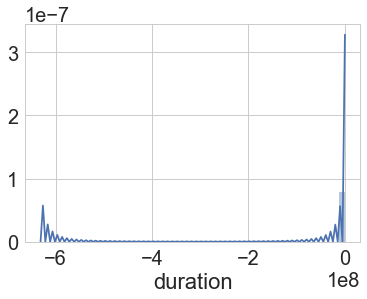

In [138]:
sns.distplot(df.duration)

In [139]:
#drop all negative and too short rides  (< 30s , 40s is lowest in test data!)
df = df.drop(df[df.duration < 30].index)

# drop all > 3h (unreasonable long, 2:30 is longest in test data)
df = df.drop(df[df.duration > 3*3600].index)

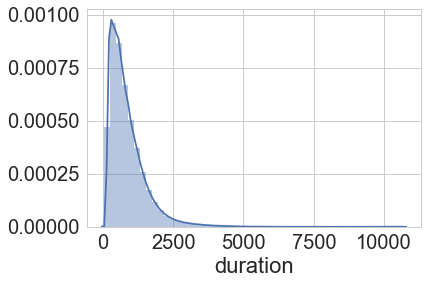

In [140]:
sns.distplot(df.duration)

df.info()

In [148]:
df.RatecodeID.value_counts()

1    8921500
2     128728
3      17522
5      15415
4       3558
Name: RatecodeID, dtype: int64

## Plot distributions

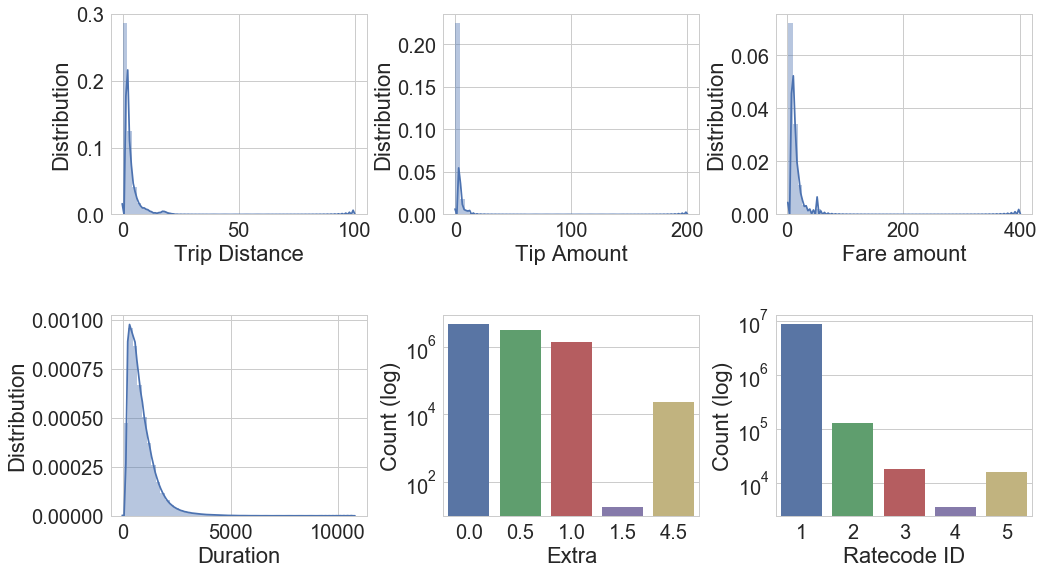

In [147]:
plt.figure(figsize=(16,9))
plt.subplot(2,3,1)
ax = sns.distplot(df.trip_distance)
ax.set(xlabel='Trip Distance', ylabel='Distribution')

plt.subplot(2,3,2)
ax = sns.distplot(df.tip_amount)
ax.set(xlabel='Tip Amount', ylabel='Distribution')

plt.subplot(2,3,3)
ax = sns.distplot(df.fare_amount)
ax.set(xlabel='Fare amount', ylabel='Distribution')

plt.subplot(2,3,4)
ax = sns.distplot(df.duration)
ax.set(xlabel='Duration', ylabel='Distribution')

plt.subplot(2,3,5)
ax = sns.countplot(df.extra)
ax.set(xlabel='Extra', ylabel='Count (log)')
ax.set_yscale('log')

plt.subplot(2,3,6)
ax = sns.countplot(df.RatecodeID)
ax.set_yscale('log')
ax.set(xlabel='Ratecode ID', ylabel='Count (log)')

plt.subplots_adjust(left=0.1, wspace=0.3, hspace=0.5, top=.9)


plt.savefig('plots/Dist.pdf')
plt.savefig('plots/Dist.png')

# Add new Attributes

In [149]:
# Calculate subtotal
df['subtotal'] = df.total_amount - df.tip_amount

# Calculating the tip percentage.
df['tip_perc'] = (df.tip_amount / df.subtotal)

df['duration'] = pd.to_datetime(df["tpep_dropoff_datetime"])-pd.to_datetime(df["tpep_pickup_datetime"])

df['duration'] = df.duration.dt.total_seconds()


df['pickup_hour'] = pd.to_datetime(df.tpep_pickup_datetime).dt.hour.astype('category')
df['RatecodeID'] = df.RatecodeID.astype('category')

df['pickup_coord']=list(zip(df.pickup_latitude, df.pickup_longitude))
df['dropoff_coord']=list(zip(df.dropoff_latitude, df.dropoff_longitude))

# Calulcate avg speed (mph)
df['avg_speed'] = (df.trip_distance)/(df.duration/3600)

In [152]:
#Clean
c = df.avg_speed.count()
df = df.drop(df[(df.trip_distance < 0.1) | (df.trip_distance > 100) ].index)
print("Dropped ",c-df.avg_speed.count()," Elements (Unreasonable trip distance)")
c = df.avg_speed.count()
df = df.drop(df[(df.avg_speed < 0.5) | (df.avg_speed > 80) ].index)
print("Dropped ",c-df.avg_speed.count()," Elements (Unreasonable speed)")
c = df.avg_speed.count()
df = df.drop(df[(df.tip_perc > .5)].index)
print("Dropped ",c-df.avg_speed.count()," Elements (Huge tip)")


Dropped  0  Elements (Unreasonable trip distance)
Dropped  0  Elements (Unreasonable speed)
Dropped  18403  Elements (Huge tip)


In [153]:
# Get Holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
dr = pd.date_range(start=df['tpep_pickup_datetime'].min(), end=df['tpep_pickup_datetime'].max())
holidays = cal.holidays(start=dr.min(), end=dr.max())
df['holiday'] = df['tpep_pickup_datetime'].isin(holidays)

In [156]:
df['overnight'] = getOvernight(df)

In [157]:
df['day'] = (pd.to_datetime(df['tpep_pickup_datetime']).dt.weekday_name)

In [159]:
df['rush_hour'] = getRushHour(df)

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9048614 entries, 0 to 11135469
Data columns (total 29 columns):
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               category
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
total_amount             float64
pickup_time              timedelta64[ns]
dropoff_time             timedelta64[ns]
duration                 float64
subtotal                 float64
tip_perc                 float64
pickup_hour              category
pickup_coord             object
dropoff_coord            object
avg_speed                float64
holiday                  bool
overn

# Check if data makes sense now

In [161]:
df.describe()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,pickup_time,dropoff_time,duration,subtotal,tip_perc,avg_speed
count,9.048614e+06,9.048614e+06,9.048614e+06,9.048614e+06,9.048614e+06,9.048614e+06,9.048614e+06,9.048614e+06,9.048614e+06,9.048614e+06,9.048614e+06,9.048614e+06,9.048614e+06,9048614,9048614,9.048614e+06,9.048614e+06,9.048614e+06,9.048614e+06
mean,1.663102e+00,2.772921e+00,-7.397500e+01,4.075149e+01,-7.397430e+01,4.075215e+01,1.393790e+00,1.255881e+01,3.311466e-01,4.986102e-01,1.609541e+00,1.895044e-01,1.548761e+01,0 days 13:53:33.549256,0 days 14:07:12.948821,8.555117e+02,1.387807e+01,1.095968e-01,1.126672e+01
std,1.309715e+00,3.260790e+00,3.499123e-02,2.743130e-02,3.413639e-02,3.169145e-02,5.023853e-01,9.915183e+00,4.209215e-01,2.632454e-02,2.289753e+00,1.172711e+00,1.224530e+01,0 days 06:26:43.175464,0 days 06:27:23.209505,6.601880e+02,1.061479e+01,1.023969e-01,5.868412e+00
min,1.000000e+00,1.000000e-01,-7.497944e+01,3.989138e+01,-7.498427e+01,3.978150e+01,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.300000e+00,0 days 00:00:00,0 days 00:00:00,3.000000e+01,3.300000e+00,0.000000e+00,5.000000e-01
25%,1.000000e+00,1.000000e+00,-7.399203e+01,4.073792e+01,-7.399138e+01,4.073652e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.300000e+00,0 days 09:19:41,0 days 09:33:39,3.990000e+02,7.800000e+00,0.000000e+00,7.313770e+00
50%,1.000000e+00,1.700000e+00,-7.398177e+01,4.075438e+01,-7.397975e+01,4.075475e+01,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.180000e+01,0 days 14:26:36,0 days 14:42:27,6.840000e+02,1.080000e+01,1.190476e-01,1.008621e+01
75%,2.000000e+00,3.100000e+00,-7.396764e+01,4.076845e+01,-7.396334e+01,4.076990e+01,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.250000e+00,0.000000e+00,1.780000e+01,0 days 19:21:54,0 days 19:35:39,1.118000e+03,1.580000e+01,2.000000e-01,1.370242e+01
max,6.000000e+00,9.996000e+01,-7.306319e+01,4.174065e+01,-7.299943e+01,4.174065e+01,5.000000e+00,4.000000e+02,4.500000e+00,5.000000e-01,9.505000e+01,3.000000e+01,4.833400e+02,0 days 23:59:59,0 days 23:59:59,1.071600e+04,4.183400e+02,5.000000e-01,8.000000e+01


In [162]:
df.trip_distance.max()

99.96

# Check Test Data

In [ ]:
test = pd.read_csv("test.csv")

In [ ]:
test.payment_type.value_counts()

In [ ]:
test[test.trip_distance > 30].RatecodeID.value_counts()

In [ ]:
test.improvement_surcharge.value_counts()

In [ ]:
test.passenger_count.value_counts()

In [ ]:
test.pickup_latitude.value_counts()

In [ ]:
#removing outliers (far away from manhattan)
manLat = 40.756716
manLong = -73.985368
margin = 1.0

print("With outliers:",np.shape(test))
test2 = test.loc[(abs(test["dropoff_latitude"]-manLat)<margin) 
                   &(abs(test["pickup_latitude"]-manLat)<margin) 
                   &(abs(test["dropoff_longitude"]-manLong)<margin) 
                   &(abs(test["pickup_longitude"]-manLong)<margin)]
print("Without outliers:",np.shape(test2))

In [ ]:
test.loc[(abs(test["dropoff_latitude"]-manLat)<margin) 
                   &(abs(test["pickup_latitude"]-manLat)<margin) 
                   &(abs(test["dropoff_longitude"]-manLong)>margin) 
                   &(abs(test["pickup_longitude"]-manLong)<margin)]

# Save

In [163]:
# Delete unused cols
df = df.drop(['holiday','pickup_coord','dropoff_coord'],axis=1)

In [ ]:
#df.to_csv('C:\\Users\\Leo\\TaxiData\\clean.csv', index=False)

In [164]:
df.to_csv('clean.csv', index=True)